# Implementation of Deep Residual Learning for Image Recognition
### By Elias Rabl Mat. Nr.: 51821309, Fabian Schmerbeck Mat. Nr.: 11734628

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from enum import Enum
import sys


## Used Dataset

We used the dataset CIFAR10 for training and testing our neural networks. The dataset contains a total of 60000 colour images, which are split into 50000 training images and 10000 test images. Each image has a resolution of 32x32 pixel. 

As the name suggests the CIFAR-10 dataset consists of 10 classes, with 6000 images each.
The dataset is further split into 5 training batches á 10000 images. Each training batch can have a different amount of pictures from the ten classes, whereas the test batch contains exactly 1000 pictures of each class.

The ten classes are:  
    * airplane
    * automobile
    * bird
    * cat
    * deer
    * dog
    * frog
    * horse
    * ship
    * truck
    
The following figure shows 10 sample images for each class:
<img src="CIFAR-10-example.PNG" width="450px" alt="CIFAR-10 example" title="CIFAR-10 example images" />

Since the Torchvision datasets are _PILImage_ images in range [0, 1] we  have to transform them to normalized Tensors in range [-1, 1].

To diversify the network input, the training images are additionally augmented by adding a 4 pixel padding on each side, cropping them back to 32x32 pixels and then randomly flipping them horizontally.


In [2]:
# training data zero-padded by 4 pixels on each side, randomly cropped to a 32x32 image and eventually flipped horizontally
# zero padding according to reference [24] - https://arxiv.org/pdf/1409.5185.pdf
tf_train = transforms.Compose(
    [transforms.RandomCrop(size=32, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # image = (image - mean) / std
     ])

# test data is simply normalized
tf_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # image = (image - mean) / std
     ])

## ---------------------------------------------- ##
# select network to be used for training
# plain nets are equal to residual nets, except that they do NOT have a shortcut connection
class NeuralNet(Enum):
    ConvNet = 1
    ResNet20 = 2
    PlainNet20 = 3
    ResNet32 = 4
    PlainNet32 = 5
    
network = NeuralNet.PlainNet32

examplesCnt = 8 # how many sample images with ground truth/prediction shall be printed?

batchSize = 200 # utilize parallel processing power of GPU, further increasing this number doesn't seem to have any effect
## ---------------------------------------------- ##

# define the data loaders for our training and test images
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tf_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tf_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=4)

# labels of the ten classes ussed for evaluation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


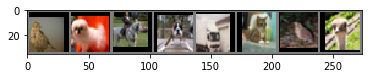

 bird,   dog, horse,   dog, truck,   cat,  bird,  bird


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = iter(trainloader).next()
images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

## Defining the neural networks:

We decided to use 3 different network architectures and compare the results each network gives.

<b> Convulutional neural network </b>
As a starter we used the basic convolutional neural network from PyTorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). We quickly realized that accuracy and training speed were far from optimal and started tweaking the parameters.
In order to increase speed we raised the batch-size from originally 4 to 200. We stopped at 200 because there was no further improvment regarding the computation time.
In order to adapt to the new batch-size we had to increase our learning rate (originally 0.001). Since the optimizer now has more images for computing the gradient. Hence it's a better approximation needs a bigger learning rate in order to efficiently improve the result. Without a larger learning rate we would need way more epoches to compensate the more precise gradient. 

Additional we decided to increase the input and output layers for the convolutions. Our thoughtprocess behind this, was to increase accuracy. Looking at more features from a picture should increase learning accuracy and lead to a better result. We tried with increasing inputplanes and stopped once we stopped noticing improvment in accuracy.
Hence the following 3 computations changed:

<b>Network definition:</b>  
self.conv1 = nn.Conv2d(3, 6, 5) -> self.conv1 = nn.Conv2d(3, 48, 5)  
self.conv2 = nn.Conv2d(6, 16, 5) -> self.conv2 = nn.Conv2d(48, 64, 5)

<b>Forward-Step</b> (This change was necessary for the network to work, not for improvment. Otherwise the dimensions for the function would not match)  
x = x.view(-1, 16 * 5 * 5) -> x = x.view(-1, 64 * 5 * 5)

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Conv2d: input, output, kernel size, (stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 48, 5) # 3 input image channel, 64 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(48, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classses output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 48 channels: conv results in 28x28 (image-kernel+1), pool => 14x14 image size
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # 64 channels: conv results in 10x10 (image-kernel+1), pool => 5x5 image size
        #print(x.shape)
        x = x.view(-1, 64 * 5 * 5)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Resnet Implementations

We chose two ResNet implementations, ResNet-20 and Resnet-32. We originally planned to use two networks with different Block-types. But from the paper description regarding the CIFAR-10 ResNets we came to the conclusion that all used networks for this image-set use basicblocks, since they state they use a stacked amount of 3x3 convolutions, which resembles the architecture of a BasicBlock (consisting of two 3x3 convolutions).  
For CIFAR-10 the implementation for the residual network skips the pooling after the first convolution, batchnorm and relu. This is indeed not needed, since we already have the desired - and very small - picture size of 32x32 pixels.  
The amount of 3x3 Convolutions for the networks is visualized in the following table:
![CIFAR-10 Layer and Filter amount](CIFAR-10-layers-filters.PNG)  
Where n starts at 3 and is increased by 2 for the following networks:
   * ResNet-20 n=3
   * ResNet-32 n=5
   
Other then the amount of layers, there is no difference in the architecture between the two residual nets.

### BasisBlock

For the BasicBlock Implementation we used the code from the lecture as a template.  

![BasicBlock](BasicBlock.png)


We introduced a new parameter _shortcut_, which allows us to easily switch from a residual network to a plain convolutional network, by simply removing the shortcut connection.

In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, 
        out_planes, 
        kernel_size=1, 
        stride=stride, 
        #padding=0
        bias=False)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, 
                     out_planes, 
                     kernel_size=3, 
                     stride=stride,
                     padding=1, # with stride=1 this preserves dimension
                     bias=False)

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, shortcut=True):
        super(BasicBlock, self).__init__()
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained), BN + ReLU
        """ 
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained) + BN
        """ 
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # needed to fix dimension incompatibility
        self.stride = stride # not actually used in class itself
        self.downsample = downsample
        self.shortcut = shortcut

    def forward(self, x):
        residual = x # preserve input for identity functionality

        # conv->bn->relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # conv->bn
        out = self.conv2(out)
        out = self.bn2(out)
        
        """
        At that point, we check if a downsampling needs to be 
        applied on x, such that F(x)+x can be computed.
        """
        if self.downsample is not None:
            residual = self.downsample(x)

        # shortcut connection: x + F(x)
        if self.shortcut:
            out += residual
        
        # building block ends with ReLU
        out = self.relu(out)

        return out


In [9]:
class ResNet20(nn.Module):
    
    def __init__(self, num_classes=10, use_shortcut=True):
        super(ResNet20, self).__init__()
        
        self.inplanes = 16
        self.conv1 = conv3x3(3, self.inplanes, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        #First layerblock
        planes = 16
        layers = []
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer1 = nn.Sequential(*layers)
        
        #Second layerblock
        planes = 32
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer2 = nn.Sequential(*layers)
        
        # Third layerblock
        planes = 64
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer3 = nn.Sequential(*layers)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * BasicBlock.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Pooling is not needed, because we don't need to downsample, our desired input size is 32 which we aready have
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
class ResNet32(nn.Module):
    
    def __init__(self, num_classes=10, use_shortcut=True):
        super(ResNet32, self).__init__()
        
        self.inplanes = 16
        self.conv1 = conv3x3(3, self.inplanes, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        #First layerblock
        planes = 16
        layers = []
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer1 = nn.Sequential(*layers)
        
        #Second layerblock
        planes = 32
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer2 = nn.Sequential(*layers)
        
        # Third layerblock
        planes = 64
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn, shortcut=use_shortcut))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        layers.append(BasicBlock(self.inplanes, planes, shortcut=use_shortcut))
        self.layer3 = nn.Sequential(*layers)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * BasicBlock.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Pooling is not needed, because we don't need to downsample, our desired input size is 32 which we aready have
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Generically select the available device that we want to use for our training.

In [50]:
# use cuda device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
# determine which network should be used:
# every training epoch has 250 iterations with each 200 images
if network == NeuralNet.ConvNet:
    net = ConvNet()
    epochCnt = 128
elif network == NeuralNet.ResNet20:
    net = ResNet20()
    epochCnt = 128
elif network == NeuralNet.PlainNet20:
    net = ResNet20(use_shortcut=False)
    epochCnt = 128
elif network == NeuralNet.ResNet32:
    net = ResNet32()
    epochCnt = 128
elif network == NeuralNet.PlainNet32:
    net = ResNet32(use_shortcut=False)
    epochCnt = 128
else:
    sys.exit("invalid network type!")

net = net.to(device)


# print number of paramters in currently selected network
netParamCnt = 0
for p in net.parameters(): netParamCnt+=p.numel()
print("%s has %d parameters." % (network.name, netParamCnt))

PlainNet32 has 466906 parameters.


## Defining a Loss function and optimizer:

Additional to the optimizer we used a scheduler to adapt our learingn rate. In the paper the same technique is used in order to achieve better results with milestones at [32000, 48000]. As a consequence we needed to increase our epoches, so the scheduler could work efficiently (decrease learning rate at least two times). This also lead to an increased amount of time our network needed for the learning proccess. Since computing 64k iterations took too long to compute, we decided to use half the iterations used in the paper, giving us a total amount of 30k iterations and two milestones at 16k and 24k iterations.

For the loss we used a Classification Cross-Entropy loss and SGD with momentum. This is the same in pytorch as well as our paper.


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16000, 24000], gamma=0.1)

## Training the network

### Training routine

In [13]:
def train(model, device, trainloader, optimizer, epoch):
    model.train() # set model to training mode
    train_loss = 0
    accuracy_per_batch = []
    
    # iterate over all batches of (img, label) from trainloader
    # images are augmented randomly by specified transformers
    for batch_idx, (data, target) in enumerate(trainloader, 1): # 50.000 test images => 250 iterations with each 200 images
        scheduler.step()
        
        # use CUDA if available
        data, target = data.to(device), target.to(device)
        
        # reset parameter gradients
        optimizer.zero_grad()
        
        # forward pass 
        output = net(data) # 10 class output
        
        # compute loss
        loss = criterion(output, target)
        
        # compute gradients
        loss.backward()
        
        # update paramters
        optimizer.step()

        # some logging
        pred = output.max(1, keepdim=True)[1]
        correctCurrentBatch = pred.eq(target.view_as(pred)).sum().item()
        accuracy_per_batch.append(100. * correctCurrentBatch / len(data))
        
        train_loss += loss.item()
        if batch_idx % 25 == 0:    # print every tenth iteration
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),    # number of images processed so far
                len(trainloader.dataset), # total number of images in trainingset
                100. * batch_idx / len(trainloader), # progress in percent
                loss.item())
            )

    train_loss /= len(trainloader)
    accuracy_per_epoch = sum(accuracy_per_batch)/len(accuracy_per_batch) #average out detailed values for further processing
    return (train_loss, accuracy_per_batch, accuracy_per_epoch)

### Testing routine

In [14]:
def test(model, device, testloader):
    model.eval() # set model to evaluation mode
    test_loss = 0
    correct = 0
    accuracy_per_batch = []
    
    # temporarily set all the requires_grad flag to False
    with torch.no_grad():
        
        # iterate over testing batches  (img, label)
        for data, target in testloader:
            
            # use CUDA if available
            data, target = data.to(device), target.to(device)
            
            # forward pass 
            output = net(data)
            
            # track cross-entropy-loss on testing data
            test_loss += criterion(output, target).item() 
            
            # get the correct class prediction as the max. value of the last fully-connected layer
            # Remember, the cross-entropy-loss operates on top of that layer! In that sense, the 
            # output of the last layer can be interpreted as the log-probability of each class.
            pred = output.max(1, keepdim=True)[1]
            
            # Track how many labels were correctly predicted
            correctCurrentBatch = pred.eq(target.view_as(pred)).sum().item()
            accuracy_per_batch.append(100. * correctCurrentBatch / len(data))
            correct += correctCurrentBatch

    # Overall testing loss
    test_loss /= len(testloader)
    accuracy_per_epoch = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss,
        correct,
        len(testloader.dataset),
        accuracy_per_epoch)
    )

    return (test_loss, accuracy_per_batch, accuracy_per_epoch)

In [ ]:
# Now, iterate over a couple of epochs ...
train_losses = []
train_accuracies_iter = []
train_accuracies_epoc = []
test_losses  = []
test_accuracies_iter = []
test_accuracies_epoc = []

# measure the time the training takes
time_start = time.process_time()

for epoch in range(1, epochCnt+1):
    train_loss, train_acc_iter, train_acc_epoc = train(net, device, trainloader, optimizer, epoch)
    test_loss, test_acc_iter, test_acc_epoc  = test(net, device, testloader)

    train_losses.append(train_loss)
    train_accuracies_iter.extend(train_acc_iter)
    train_accuracies_epoc.append(train_acc_epoc)
    test_losses.append(test_loss)
    test_accuracies_iter.extend(test_acc_iter)
    test_accuracies_epoc.append(test_acc_epoc)


print('Finished Training (duration %.3f sec)' % (time.process_time() - time_start))

Plot the results of the training process:
* loss over iterations
* error over iterations (after each epoch)
* error over iterations (average per epoch)

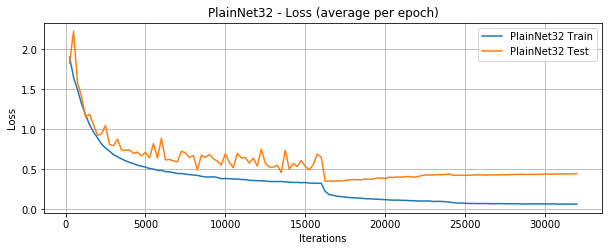

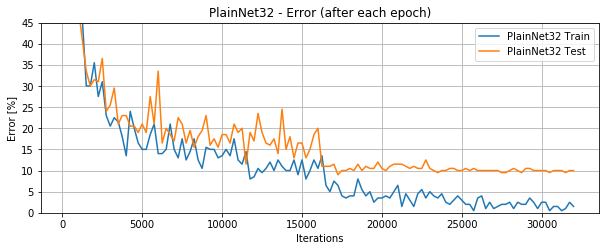

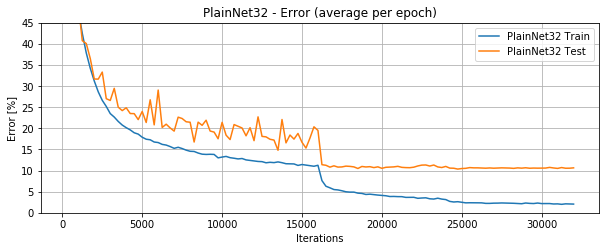

In [16]:
x = np.arange(len(trainloader), (epochCnt+1)*len(trainloader), len(trainloader))

plt.figure(figsize=(10,3.5))
plt.plot(x, train_losses, lw=1.5)
plt.plot(x, test_losses, lw=1.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(network.name + ' - Loss (average per epoch)')
plt.legend([network.name + ' Train', network.name + ' Test'])
plt.grid()
plt.savefig('results/' + network.name + '_epochs_' + str(epochCnt) + '_loss.png', bbox_inches='tight', dpi=300)

# we have one accuracy value per iteration
#  => training: 50000/200 = 250 iterations per epoch
#  => testing:  10000/200 =  50 iterations per epoch
# => only use every nth element of list (alternatively one could implement a moving average or similar)
train_accuracies_reduced = train_accuracies_iter[0::len(trainloader)]
test_accuracies_reduced = test_accuracies_iter[0::len(testloader)]

plt.figure(figsize=(10,3.5))
plt.plot(x, 100-np.array(train_accuracies_reduced), lw=1.5)
plt.plot(x, 100-np.array(test_accuracies_reduced), lw=1.5)
plt.xlabel('Iterations')
plt.ylabel('Error [%]')
plt.title(network.name + ' - Error (after each epoch)')
plt.legend([network.name + ' Train', network.name + ' Test'])
plt.ylim((0,45))
plt.grid()
plt.savefig('results/' + network.name + '_epochs_' + str(epochCnt) + '_error.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(10,3.5))
plt.plot(x, 100-np.array(train_accuracies_epoc), lw=1.5)
plt.plot(x, 100-np.array(test_accuracies_epoc), lw=1.5)
plt.xlabel('Iterations')
plt.ylabel('Error [%]')
plt.title(network.name + ' - Error (average per epoch)')
plt.legend([network.name + ' Train', network.name + ' Test'])
plt.ylim((0,45))
plt.grid()
plt.savefig('results/' + network.name + '_epochs_' + str(epochCnt) + '_error_avg.png', bbox_inches='tight', dpi=300)

## Testing the network

Original we used two epoches for the non-residual network. While using the Res-Net we noticed that 2 epoches were not enough especially when using a scheduler for the learning rate. We decided to use 5 epoch in order to get at least two learning-rate reductions. This should be enough since we did not notice any additional change to our loss. Especially for lower learning rates.

In order to check the results our networks have achieved we decided to use the template from pytorch and the lecture, splitting in in 3 parts:
    * Check 8 sample images and their computed labels
    * Total Accuracy
    * Class Accuracy

<b>Sample Images with computed labels:</b>

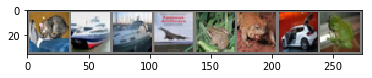

GroundTruth:    cat,  ship,  ship, plane,  frog,  frog,   car,  frog


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

<b>Predicted Classes from our network:</b>

In [18]:
# move input to cuda device if available
images = images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join('%5s' % classes[predicted[j]] for j in range(examplesCnt)))

Predicted:    cat,  ship,  ship, plane,  frog,  frog,   car,  frog


<b>Total Accuracy:</b>

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %2d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


<b>Class Accuracy:</b>

In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(batchSize):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 91 %
Accuracy of   car: 95 %
Accuracy of  bird: 85 %
Accuracy of   cat: 78 %
Accuracy of  deer: 88 %
Accuracy of   dog: 84 %
Accuracy of  frog: 91 %
Accuracy of horse: 91 %
Accuracy of  ship: 93 %
Accuracy of truck: 94 %


***
## Discussion
Overall we were very satisfied with our results. All training runs achieved very similar results to the guide models from our paper. The graphs also show, that increasing layers in residual nets, improves the accuracy, even if the final accuracy does not replicate this. This can be seen from the two respecting graphs. Altough the difference is only about 1%, it is still visible.  
Additional we could show that increasing layers in a plain network does not yield the same result, but instead decreases accuracy. Again the change is very small but still noticable.
Finally our first learning rate adaption at 16k iterations shows real impact on the accuracy and loss, which was exactly what we hoped for.

## Results:
### ConvNet:
#### Parameters: 283646
#### Loss
<img src="results/ConvNet_epochs_128_loss.png" width="650px" alt="Loss ConvNet for 128 epoches" title="Loss ConvNet for 128 epoches"/>
#### Average error
<img src="results/ConvNet_epochs_128_error_avg.png" width="650px" alt="Average Error ConvNet for 128 epoches" title="Average Error ConvNet for 128 epoches"/>
#### Total accuracy
* Accuracy of the network on the 10000 test images: 83 %
#### Class accuracy
* Accuracy of plane: 85 %
* Accuracy of   car: 91 %
* Accuracy of  bird: 78 %
* Accuracy of   cat: 69 %
* Accuracy of  deer: 83 %
* Accuracy of   dog: 73 %
* Accuracy of  frog: 88 %
* Accuracy of horse: 86 %
* Accuracy of  ship: 91 %
* Accuracy of truck: 88 %

<br><br>
***
### PlainNet20
#### Parameters: 272474
#### Loss
<img src="results/PlainNet20_epochs_128_loss.png" width="650px" alt="Loss PlainNet for 128 epoches" title="Loss PlainNet for 128 epoches"/>
#### Average error
<img src="results/PlainNet20_epochs_128_error_avg.png" width="650px" alt="Average Error PlainNet20 for 128 epoches" title="Average Error PlainNet20 for 128 epoches"/>
#### Total accuracy
Accuracy of the network on the 10000 test images: 90 %
#### Class accuracy
* Accuracy of plane: 93 %
* Accuracy of   car: 96 %
* Accuracy of  bird: 86 %
* Accuracy of   cat: 78 %
* Accuracy of  deer: 90 %
* Accuracy of   dog: 82 %
* Accuracy of  frog: 93 %
* Accuracy of horse: 91 %
* Accuracy of  ship: 94 %
* Accuracy of truck: 94 %  

<br><br>
***
### ResNet20
#### Parameters: 272474
#### Loss
<img src="results/ResNet20_epochs_128_loss.png" width="650px" alt="Loss ResNet20 for 128 epoches" title="Loss ResNet20 for 128 epoches"/>
#### Average error
<img src="results/ResNet20_epochs_128_error_avg.png" width="650px" alt="Average Error ResNet20 for 128 epoches" title="Average Error ResNet20 for 128 epoches"/>
#### Total accuracy
Accuracy of the network on the 10000 test images: 91 %
#### Class accuracy
* Accuracy of plane: 92 %
* Accuracy of   car: 95 %
* Accuracy of  bird: 87 %
* Accuracy of   cat: 78 %
* Accuracy of  deer: 92 %
* Accuracy of   dog: 86 %
* Accuracy of  frog: 93 %
* Accuracy of horse: 94 %
* Accuracy of  ship: 94 %
* Accuracy of truck: 95 %  

<br><br>
***
### PlainNet32
#### Parameters: 466906
#### Loss
<img src="results/PlainNet32_epochs_128_loss.png" width="650px" alt="Loss PlainNet32 for 128 epoches" title="Loss PlainNet32 for 128 epoches"/>
#### Average error
<img src="results/PlainNet32_epochs_128_error_avg.png" width="650px" alt="Average Error PlainNet32 for 128 epoches" title="Average Error PlainNet32 for 128 epoches"/>
#### Total accuracy
Accuracy of the network on the 10000 test images: 89 %
#### Class accuracy
* Accuracy of plane: 91 %
* Accuracy of   car: 95 %
* Accuracy of  bird: 85 %
* Accuracy of   cat: 78 %
* Accuracy of  deer: 88 %
* Accuracy of   dog: 84 %
* Accuracy of  frog: 91 %
* Accuracy of horse: 91 %
* Accuracy of  ship: 93 %
* Accuracy of truck: 94 %

<br><br>
***
### ResNet32
#### Parameters: 466906
#### Loss
<img src="results/ResNet32_epochs_128_loss.png" width="650px" alt="Loss ResNet32 for 128 epoches" title="Loss ResNet32 for 128 epoches"/>
#### Average error
<img src="results/ResNet32_epochs_128_error_avg.png" width="650px" alt="Average Error ResNet32 for 128 epoches" title="Average Error ResNet32 for 128 epoches"/>
#### Total accuracy
Accuracy of the network on the 10000 test images: 91 %
#### Class accuracy
* Accuracy of plane: 94 %
* Accuracy of   car: 96 %
* Accuracy of  bird: 88 %
* Accuracy of   cat: 80 %
* Accuracy of  deer: 93 %
* Accuracy of   dog: 86 %
* Accuracy of  frog: 94 %
* Accuracy of horse: 94 %
* Accuracy of  ship: 94 %
* Accuracy of truck: 94 %  
